# 2_models: Demand Modeling & Price‐Response Grid

This notebook will:
1. Load processed slot‐level data  
2. Perform slot‐level clustering  
3. Train demand‐prediction models (baseline & GBMs)  
4. Generate and save price‐response grid  


In [1]:
# 2.0 Parameters & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import lightgbm as lgb
import catboost as cb
import optuna

# explainability
import shap

c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH = "../data/processed/"

## Data Loading & Validation

In [3]:
# load slot-level file
df = pd.read_parquet(PATH + "full_clean.parquet")

df.head()

,Context ID,Session ID,Customer ID,Search Date At,Year At,Month At,Day At,Search Hour At,Search Date For,Year For,...,Promo Code,Promo Code Applied,Reservation Cost (£),Packages Cost (£),Add Ons Cost (£),Promo Code Discount (£),Total Cost (£),Deposit Amount,Started a Booking Draft,Was Booked
0,20240801000316DQ6C,81.98.105.115,None,2024-08-01,2024,8,8.0,00:03:52,2024-08-02,2024,...,None,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,2024080100046GWKPO,81.98.105.115,202408010006KZKP9I,2024-08-01,2024,8,8.0,00:04:39,2024-08-02,2024,...,None,0,24.0,0.0,0.0,0.0,24.0,24.0,1,1
2,202408010004Y09YOM,81.98.105.115,None,2024-08-01,2024,8,8.0,00:04:04,2024-08-02,2024,...,None,0,24.0,0.0,0.0,0.0,24.0,24.0,1,0
3,2024080100079BZCQ0,147.161.166.186,None,2024-08-01,2024,8,8.0,00:07:51,2024-08-03,2024,...,None,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,202408010008I220PD,147.161.166.186,None,2024-08-01,2024,8,8.0,00:08:16,2024-08-03,2024,...,None,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


## DB for K-Means


In [4]:

# Step 1: Filter non-zero charges to get valid price-per-person averages
# Precompute the relevant columns in the original df
df['valid_price'] = np.where(df['Search Charge'] > 0, df['Search Charge'], 0)
df['booked_party_size'] = np.where(df['Was Booked'] == 1, df['Party Size'], 0)



# Step 2: Group and aggregate
search_db = df.groupby(['Venue Name', 'Day of the Week', 'Search Hour For']).agg( 
        # dropped Month For as we want a generic hour-of-week profile that blends all months, 
        # not separate clusters per calendar month
    search_count=('Context ID', 'count'),
    search_party=('Party Size', 'mean'),            # (all rows),
    booked_party=('booked_party_size', 'mean'),     # where Was Booked==1,
    availability=('Was Search Available', 'mean'), 
    avg_price_pp=('valid_price', 'mean')
).reset_index()

# Step 3: Inspect results
print("\nSearch database structure:")
print(search_db.head())
print(f"\nShape: {search_db.shape}")
print(f"Unique venues: {search_db['Venue Name'].unique()}")



Search database structure:
         Venue Name Day of the Week Search Hour For  search_count  \
0  Clays Birmingham          Friday              12           565   
1  Clays Birmingham          Friday              13           779   
2  Clays Birmingham          Friday              14          1187   
3  Clays Birmingham          Friday              15          1068   
4  Clays Birmingham          Friday              16           986   

   search_party  booked_party  availability  avg_price_pp  
0      4.014159      0.438938      0.913274      7.982301  
1      4.265725      0.296534      0.943517      8.243902  
2      4.801179      0.521483      0.946925      8.152485  
3      6.026217      0.412921      0.957865     10.638577  
4      5.594320      0.460446      0.998986     10.725152  

Shape: (252, 8)
Unique venues: ['Clays Birmingham' 'Clays Canary Wharf' 'Clays, The City']


## Short Initial Edits 

In [5]:
rename_mapping = {
    "Search Hour For": "search_hour_for",
    "Month For": "month_for",
    "Day of the Week": "day_of_week_for"
}

# Apply the renaming
search_db = search_db.rename(columns=rename_mapping)

# ----- Map day names to integers
day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}
search_db['day_of_week_for'] = search_db['day_of_week_for'].map(day_mapping)

# ----- Ensure search_hour_for is numeric (it might be string type!)
search_db['search_hour_for'] = pd.to_numeric(search_db['search_hour_for'], errors='coerce')

# ----- Create hour_of_week column
# This will range from (0 * 24 + 12 = 12) up to (6 * 24 + 23 = 167)
search_db['hour_of_week'] = search_db['day_of_week_for'] * 24 + search_db['search_hour_for']

# ----- Venue overview
venues = search_db['Venue Name'].unique()
print(f"Venues to analyze: {venues}")
print(f"Number of venues: {len(venues)}")


Venues to analyze: ['Clays Birmingham' 'Clays Canary Wharf' 'Clays, The City']
Number of venues: 3


## Pivot / Feature-Matrix per Venue 

In [6]:

# Store results for all venues
venue_results = {}

# Process each venue
for venue in venues:
    print(f"\n{'='*50}")
    print(f"Processing: {venue}")
    print(f"{'='*50}")
    
    # Filter for specific venue
    venue_data = search_db[search_db['Venue Name'] == venue].copy()
    
    # Create feature matrix grouped by hour_of_week
    feature_matrix = (
        venue_data
        .groupby('hour_of_week')
        .agg(
            avg_search_party=('search_party', 'mean'),
            avg_booking_party=('booked_party', 'mean'),
            availability_rate=('availability', 'mean'),
            avg_price_pp=('avg_price_pp', 'mean')
        )
    )
    
    feature_matrix = feature_matrix.fillna(feature_matrix.median(numeric_only=True))

    # --- Add time-based enrichments ---
    # Extract hour and day from hour_of_week
    feature_matrix['day_of_week'] = feature_matrix.index // 24
    feature_matrix['hour_of_day'] = feature_matrix.index % 24

    # Cyclic encodings for hour of day
    feature_matrix['hour_sin'] = np.sin(2 * np.pi * feature_matrix['hour_of_day'] / 24)
    feature_matrix['hour_cos'] = np.cos(2 * np.pi * feature_matrix['hour_of_day'] / 24)

    # Weekend flag
    feature_matrix['is_weekend'] = feature_matrix['day_of_week'].isin([5, 6]).astype(int)

    # Business hour flag (14h–18h inclusive)
    feature_matrix['is_business_hour'] = feature_matrix['hour_of_day'].between(14, 18).astype(int)

    # Lunch hour flag (12h–14h inclusive)
    feature_matrix['is_lunch_hour'] = feature_matrix['hour_of_day'].between(12, 14).astype(int)
    
    # Duration logic
    def get_duration(party_size):
        if party_size <= 2:
            return 45
        elif party_size <= 5:
            return 60
        else:
            return 90

    # Apply per row (rounded party size)
    search_db['rounded_party'] = search_db['search_party'].round().fillna(0).astype(int)
    search_db['duration_minutes'] = search_db['rounded_party'].apply(get_duration)

    # Clean up
    search_db.drop(columns='rounded_party', inplace=True)


    # Store in results temporarily — cleaning happens below
    venue_results[venue] = {
        'features': feature_matrix,  # Unfiltered version
        'venue_data': venue_data
        
    
    }



Processing: Clays Birmingham

Processing: Clays Canary Wharf

Processing: Clays, The City


## Handling Missing Values & Filtering Sparse Slots

In [7]:
# Assuming df is the full original dataset (with all venues & hour-level data)

# Convert to numeric if still string
df['Search Hour For'] = pd.to_numeric(df['Search Hour For'], errors='coerce')
df['Search Date For'] = pd.to_datetime(df['Search Date For'], errors='coerce')
df['day_of_week_for'] = df['Search Date For'].dt.dayofweek

# Recreate day_of_week and hour_of_week
df['day_of_week_for'] = df['Search Date For'].dt.dayofweek
df['hour_of_week'] = df['day_of_week_for'] * 24 + df['Search Hour For']

# Create year-week indicator
df['year_week'] = df['Search Date For'].dt.strftime('%Y-%U')

# Count unique weeks each hour_of_week appears in
week_counts = (
    df.groupby('hour_of_week')['year_week']
    .nunique()
    .rename('num_weeks')
)

display(df.head(3).T)

,0,1,2
Context ID,20240801000316DQ6C,2024080100046GWKPO,202408010004Y09YOM
Session ID,81.98.105.115,81.98.105.115,81.98.105.115
Customer ID,None,202408010006KZKP9I,None
Search Date At,2024-08-01,2024-08-01,2024-08-01
Year At,2024,2024,2024
Month At,8,8,8
Day At,8.0,8.0,8.0
Search Hour At,00:03:52,00:04:39,00:04:04
Search Date For,2024-08-02 00:00:00,2024-08-02 00:00:00,2024-08-02 00:00:00
Year For,2024,2024,2024


## Find Optimal K for Each Venue


Finding optimal k for: Clays Birmingham
Number of samples: 84
Testing k values from 2 to 8


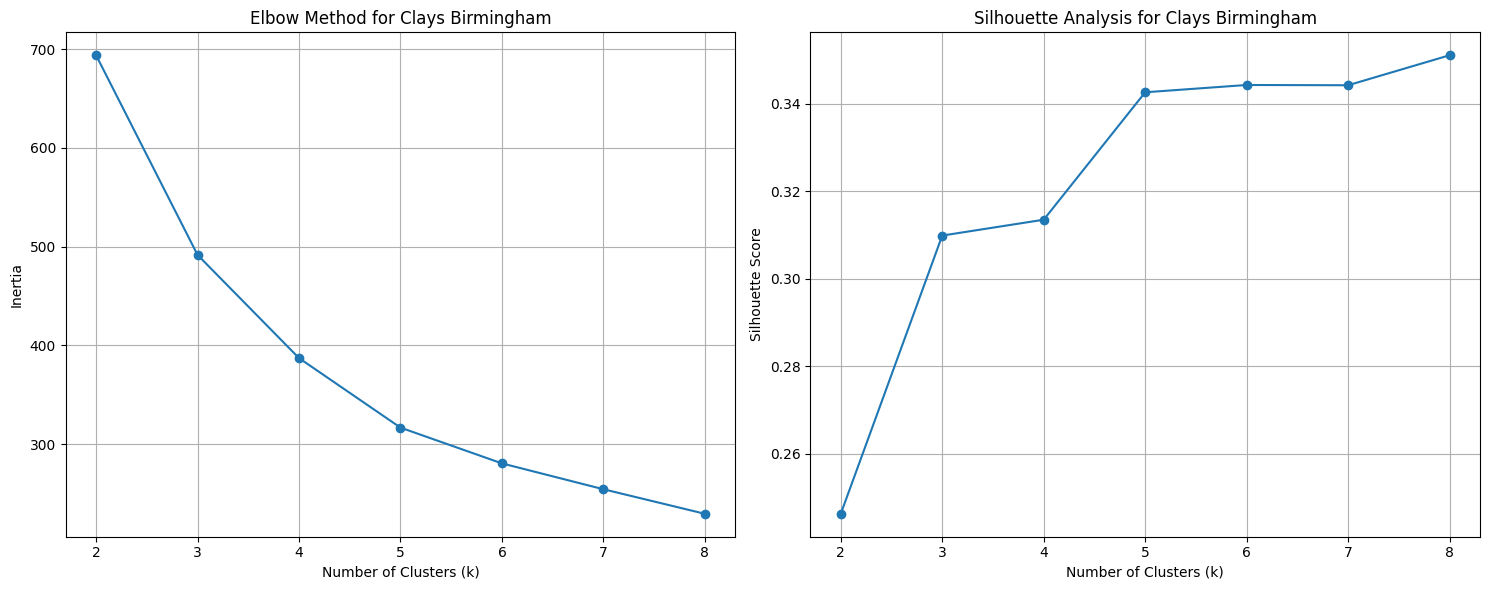


Finding optimal k for: Clays Canary Wharf
Number of samples: 84
Testing k values from 2 to 8


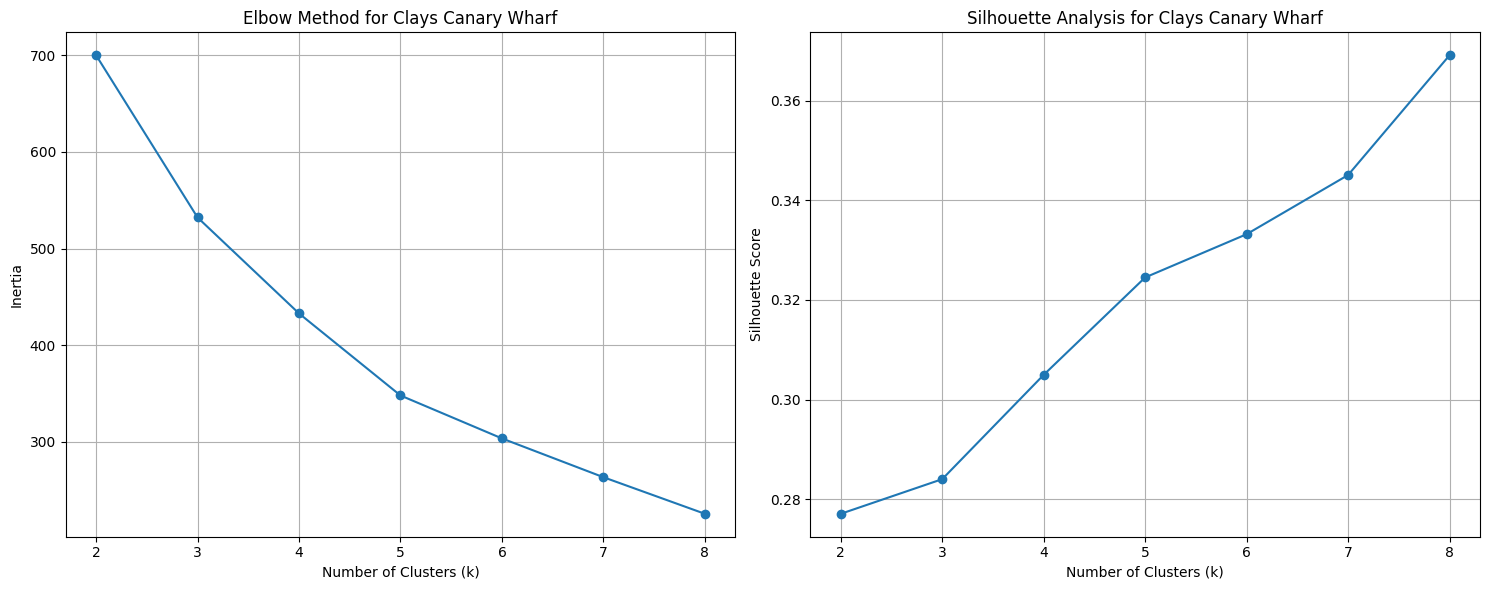


Finding optimal k for: Clays, The City
Number of samples: 84
Testing k values from 2 to 8


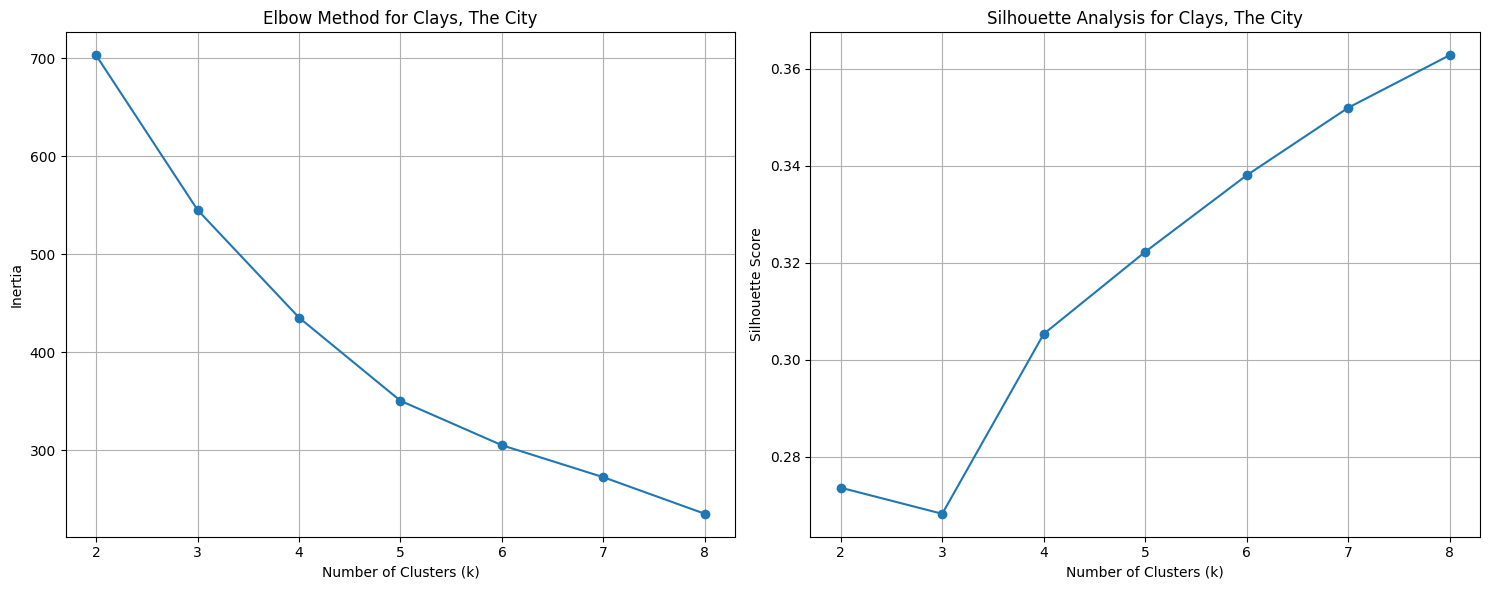

In [8]:
# Find optimal k for each venue
for venue, results in venue_results.items():
    print(f"\n{'='*50}")
    print(f"Finding optimal k for: {venue}")
    print(f"{'='*50}")
    
    feature_matrix = results['features']
    
    # Fix: Convert all column names to strings
    feature_matrix.columns = feature_matrix.columns.astype(str)
    
    # Check if we have enough samples for clustering
    n_samples = len(feature_matrix)
    print(f"Number of samples: {n_samples}")
    
    if n_samples < 4:
        print(f"WARNING: {venue} has only {n_samples} samples. Skipping clustering.")
        results['warning'] = f"Too few samples ({n_samples}) for clustering"
        continue
    
    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(feature_matrix)
    
    # Adjust k_range based on sample size
    max_k = min(8, n_samples - 1)  # k must be less than n_samples
    k_range = range(2, max_k + 1)
    
    print(f"Testing k values from 2 to {max_k}")
    
    inertias = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features_scaled)
        inertias.append(kmeans.inertia_)
        
        # Only calculate silhouette score if k < n_samples
        if k < n_samples:
            silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))
        else:
            silhouette_scores.append(np.nan)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.plot(k_range, inertias, marker='o')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title(f'Elbow Method for {venue}')
    ax1.grid(True)
    
    # Plot silhouette scores (excluding NaN values)
    valid_scores = [(k, s) for k, s in zip(k_range, silhouette_scores) if not np.isnan(s)]
    if valid_scores:
        valid_k, valid_scores = zip(*valid_scores)
        ax2.plot(valid_k, valid_scores, marker='o')
    
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title(f'Silhouette Analysis for {venue}')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Store scaler and metrics for later use
    results['scaler'] = scaler
    results['features_scaled'] = features_scaled
    results['k_metrics'] = {
        'k_range': k_range,
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'max_k': max_k
    }

## Set Optimal K and Apply Final Clustering

In [9]:
# Set optimal k for each venue
venue_optimal_k = {
    'Clays Birmingham': 4,
    'Clays Canary Wharf': 5,
    'Clays, The City': 5
}

# Apply final clustering
final_venue_results = {}

for venue, results in venue_results.items():
    print(f"\n{'='*50}")
    print(f"Final clustering for: {venue}")
    print(f"{'='*50}")
    
    # Skip venues with warnings
    if 'warning' in results:
        print(f"Skipping {venue}: {results['warning']}")
        continue
    
    # Using optimal k per venue
    if venue not in venue_optimal_k:
        raise ValueError(f"Venue '{venue}' not found in venue_optimal_k. Please define its optimal k value.")
    optimal_k = venue_optimal_k[venue]
    print(f"Using k = {optimal_k}")

    
    # Retrieve scaled features
    features_scaled = results['features_scaled']
    
    # Fit model and assign cluster labels
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = final_kmeans.fit_predict(features_scaled)
    
    # Assign cluster labels to the original feature matrix
    feature_matrix = results['features'].copy()
    feature_matrix['cluster'] = cluster_labels
    
    # Create a summary using actual available columns
    cluster_summary = feature_matrix.groupby('cluster').agg({
        'avg_booking_party': 'mean',
        'avg_price_pp': 'mean',
        'availability_rate': 'mean',
        'is_weekend': 'mean',
        'is_business_hour': 'mean',
        'is_lunch_hour': 'mean'
    }).round(2)

    print("\nCluster summary:")
    print(cluster_summary)
    
    # Save results
    final_venue_results[venue] = {
        'model': final_kmeans,
        'clustered_features': feature_matrix,
        'cluster_summary': cluster_summary,
        'optimal_k': optimal_k
    }



Final clustering for: Clays Birmingham
Using k = 4

Cluster summary:
         avg_booking_party  avg_price_pp  availability_rate  is_weekend  \
cluster                                                                   
0                     0.50          9.96               0.96        0.29   
1                     0.19          1.79               0.21        0.27   
2                     0.41          7.64               0.87        0.29   
3                     0.52          8.41               0.93        0.29   

         is_business_hour  is_lunch_hour  
cluster                                   
0                    1.00            0.0  
1                    0.00            0.0  
2                    0.33            1.0  
3                    0.00            0.0  

Final clustering for: Clays Canary Wharf
Using k = 5

Cluster summary:
         avg_booking_party  avg_price_pp  availability_rate  is_weekend  \
cluster                                                                   

## Assign Meaningful Names to Clusters

In [10]:
# Assign names to clusters based on booking patterns
for venue, results in final_venue_results.items():
    print(f"\n{'='*50}")
    print(f"Assigning cluster names for: {venue}")
    print(f"{'='*50}")
    
    feature_matrix = results['clustered_features']

    # Compute sorting metric: composite score (you could also pick just one)
    cluster_characteristics = feature_matrix.groupby('cluster').agg({
        'avg_booking_party': 'mean',
        'avg_price_pp': 'mean',
        'availability_rate': 'mean'
    })
    cluster_characteristics['composite_score'] = (
        cluster_characteristics['avg_booking_party'] * cluster_characteristics['avg_price_pp'] * cluster_characteristics['availability_rate']
    )

    # Sort clusters by composite score (higher = more valuable slot)
    cluster_characteristics = cluster_characteristics.sort_values('composite_score', ascending=False)
    print("Cluster ranking (composite booking value):")
    print(cluster_characteristics)

    # Assign human-readable names based on rank
    cluster_names = {}
    labels = ['Super Peak', 'Peak', 'Normal', 'Moderate', 'Low Traffic'][:len(cluster_characteristics)]

    for idx, cluster_id in enumerate(cluster_characteristics.index):
        cluster_names[cluster_id] = labels[idx]

    # Apply the names
    feature_matrix['cluster_name'] = feature_matrix['cluster'].map(cluster_names)

    print(f"\nCluster names for {venue}:")
    print(cluster_names)

    # Update results
    results['cluster_names'] = cluster_names
    results['clustered_features'] = feature_matrix



Assigning cluster names for: Clays Birmingham
Cluster ranking (composite booking value):
         avg_booking_party  avg_price_pp  availability_rate  composite_score
cluster                                                                     
0                 0.497028      9.956278           0.960044         4.750822
3                 0.515379      8.410419           0.926803         4.017271
2                 0.413643      7.640114           0.870732         2.751756
1                 0.187539      1.790522           0.211673         0.071078

Cluster names for Clays Birmingham:
{0: 'Super Peak', 3: 'Peak', 2: 'Normal', 1: 'Moderate'}

Assigning cluster names for: Clays Canary Wharf
Cluster ranking (composite booking value):
         avg_booking_party  avg_price_pp  availability_rate  composite_score
cluster                                                                     
1                 0.390894     10.088740           0.848175         3.344890
4                 0.334303     

## Add Cluster Assignments to search_db

In [11]:
# Add cluster assignments to search_db using hour_of_week (no more month_for)
print("Creating cluster assignment mapping...")

# Build all cluster assignments
all_cluster_assignments = []

for venue, results in final_venue_results.items():
    cf = results['clustered_features']
    cluster_names = results['cluster_names']

    for hour_of_week, row in cf.iterrows():
        cluster = row['cluster']
        cluster_name = cluster_names.get(cluster, f"Cluster_{cluster}")
        
        # Decode hour_of_week to day and hour
        day_of_week = int(hour_of_week) // 24
        hour = int(hour_of_week) % 24

        assignment = {
            'Venue Name': venue,
            'hour_of_week': hour_of_week,
            'day_of_week': day_of_week,
            'hour': hour,
            'cluster': cluster,
            'cluster_name': cluster_name
        }
        all_cluster_assignments.append(assignment)

# Create a DataFrame of cluster mappings
cluster_assignments_df = pd.DataFrame(all_cluster_assignments)

# Merge with the main search_db on Venue Name + hour_of_week
search_db_with_clusters = search_db.merge(
    cluster_assignments_df,
    on=['Venue Name', 'hour_of_week'],
    how='left'
)

# Display cluster assignment summary
print("\nCluster assignment summary:")
summary = search_db_with_clusters.groupby('Venue Name').agg(
    total_records=('cluster', 'count'),
    records_with_clusters=('cluster_name', 'count')
)
print(summary)

# Show a small sample to verify the merge
print("\nSample of search_db with clusters:")
sample_data = search_db_with_clusters.groupby('Venue Name').head(3)
print(sample_data[['Venue Name', 'day_of_week_for', 'search_hour_for', 'hour_of_week', 'cluster', 'cluster_name']])


Creating cluster assignment mapping...

Cluster assignment summary:
                    total_records  records_with_clusters
Venue Name                                              
Clays Birmingham               84                     84
Clays Canary Wharf             84                     84
Clays, The City                84                     84

Sample of search_db with clusters:
             Venue Name  day_of_week_for  search_hour_for  hour_of_week  \
0      Clays Birmingham                4               12           108   
1      Clays Birmingham                4               13           109   
2      Clays Birmingham                4               14           110   
84   Clays Canary Wharf                4               12           108   
85   Clays Canary Wharf                4               13           109   
86   Clays Canary Wharf                4               14           110   
168     Clays, The City                4               12           108   
169     Cla

## Verify Cluster Assignments

In [12]:
# Verify cluster assignments by checking coverage
print("=== Cluster Assignment Verification ===")

for venue in venues:
    print(f"\n{venue}:")
    venue_data = search_db_with_clusters[search_db_with_clusters['Venue Name'] == venue]
    
    total_records = len(venue_data)
    records_with_clusters = venue_data['cluster'].notna().sum()
    coverage = (records_with_clusters / total_records) * 100 if total_records > 0 else 0
    
    print(f"  Total records: {total_records}")
    print(f"  Records with clusters: {records_with_clusters}")
    print(f"  Coverage: {coverage:.1f}%")
    
    # Show cluster distribution
    if records_with_clusters > 0:
        cluster_dist = venue_data['cluster_name'].value_counts()
        print(f"  Cluster distribution:")
        for cluster, count in cluster_dist.items():
            pct = (count / records_with_clusters) * 100
            print(f"    {cluster}: {count} ({pct:.1f}%)")
    
    # Check for missing combinations
    if coverage < 100:
        missing_data = venue_data[venue_data['cluster'].isna()]
        missing_combinations = missing_data[['search_hour_for', 'month_for']].drop_duplicates()
        print(f"  Missing combinations: {len(missing_combinations)}")
        if len(missing_combinations) > 0:
            print(f"  Sample missing: {missing_combinations.head().values.tolist()}")

=== Cluster Assignment Verification ===

Clays Birmingham:
  Total records: 84
  Records with clusters: 84
  Coverage: 100.0%
  Cluster distribution:
    Super Peak: 28 (33.3%)
    Peak: 24 (28.6%)
    Normal: 21 (25.0%)
    Moderate: 11 (13.1%)

Clays Canary Wharf:
  Total records: 84
  Records with clusters: 84
  Coverage: 100.0%
  Cluster distribution:
    Peak: 26 (31.0%)
    Super Peak: 22 (26.2%)
    Normal: 17 (20.2%)
    Moderate: 14 (16.7%)
    Low Traffic: 5 (6.0%)

Clays, The City:
  Total records: 84
  Records with clusters: 84
  Coverage: 100.0%
  Cluster distribution:
    Super Peak: 23 (27.4%)
    Peak: 22 (26.2%)
    Moderate: 18 (21.4%)
    Normal: 16 (19.0%)
    Low Traffic: 5 (6.0%)


## Saving the Clusters

In [20]:
# === Final optimizer-ready file: clusters.csv ===
# Group by venue, day, hour, and cluster
optimizer_clusters = (
    search_db_with_clusters
    .groupby(['Venue Name', 'day_of_week', 'search_hour_for', 'cluster_name'])
    .agg(
        search_count=('search_count', 'sum'),
        predicted_demand=('booked_party', 'mean'),      # To be replaced by model later
        avg_party_size=('search_party', 'mean'),
        duration_minutes=('duration_minutes', 'mean')
    )
    .reset_index()
)

# Rename columns for clarity
optimizer_clusters = optimizer_clusters.rename(columns={
    'Venue Name': 'venue',
    'day_of_week': 'day_of_week',
    'search_hour_for': 'hour'
})

# Save to CSV
optimizer_clusters.to_csv(PATH + "clusters.csv", index=False)
print(f"✅ Saved final optimizer-ready file to {PATH}clusters.csv")

# Save to Parquet
optimizer_clusters.to_parquet(PATH + "clusters.parquet", index=False)
print(f"✅ Saved final optimizer-ready file to {PATH}clusters.parquet")


✅ Saved final optimizer-ready file to ../data/processed/clusters.csv
✅ Saved final optimizer-ready file to ../data/processed/clusters.parquet


In [21]:
# Preview
optimizer_clusters.head()

,venue,day_of_week,hour,cluster_name,search_count,predicted_demand,avg_party_size,duration_minutes
0,Clays Birmingham,0,12,Normal,290,0.155172,3.189655,60.0
1,Clays Birmingham,0,13,Normal,313,0.242812,4.306709,60.0
2,Clays Birmingham,0,14,Normal,412,0.300971,4.628641,60.0
3,Clays Birmingham,0,15,Super Peak,282,0.531915,4.648936,60.0
4,Clays Birmingham,0,16,Super Peak,315,0.774603,5.279365,60.0
